# SWE Regressor vs. MODIS pixel quality

In [1]:
# Make sure the util directory is available for importing
import os
import sys
if 'notebooks' in os.getcwd():
    os.chdir("..")
    sys.path.append(os.getcwd())
    print("Changed path to", os.getcwd())

from util.small_training import ETHoleTiny, compare_spatial_output

Changed path to /home/jovyan/swe_forecasting_prod


In [15]:
import pandas as pd
from matplotlib import pyplot as plt

### Train model on a subset of the original data

See if we can reproduce the speckling problem.

In [2]:
et = ETHoleTiny()

In [3]:
smallfile = "/home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small.csv"

In [4]:
chosen_columns = [
  'swe_value',
  'cumulative_SWE',
  'fsca',
  'air_temperature_tmmx', 
  'air_temperature_tmmn', 
  'potential_evapotranspiration', 
  'relative_humidity_rmax', 
  'Elevation',	
  'Slope',	
  'Curvature',	
  'Aspect',	
  'Eastness',	
  'Northness',
]

et.preprocess_data(smallfile, verbose=True, chosen_columns=chosen_columns)

Using file /home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small.csv
Shape: (10000, 105)
Using features Index(['cumulative_SWE', 'fsca', 'air_temperature_tmmx',
       'air_temperature_tmmn', 'potential_evapotranspiration',
       'relative_humidity_rmax', 'Elevation', 'Slope', 'Curvature', 'Aspect',
       'Eastness', 'Northness'],
      dtype='object')
Descriptive statistics
-- Training data --
       cumulative_SWE         fsca  air_temperature_tmmx  \
count     6774.000000  6774.000000           6774.000000   
mean         0.136495     5.948830            217.309994   
std          1.757386    17.304665            126.301994   
min         -1.000000     0.000000              0.000000   
25%         -1.000000     0.000000              0.000000   
50%         -1.000000     0.000000            286.100000   
75%          1.820106     0.000000            295.775147   
max          4.371002    93.000000            320.000000   

       air_temperatur

In [5]:
et.fit()

In [6]:
et.evaluate()

{'rmse': 3.445828786815195,
 'mae': 1.0731719557195574,
 'r2': 0.4738548492798256}

In [9]:
predict_data = pd.read_csv("/home/jovyan/shared-public/ml_swe_monitoring_prod/test_data_predicted_latest_2023-12-15_REDUCEDPNW.csv")
predict_data = predict_data.dropna(subset=chosen_columns[1:])

In [10]:
predict_data.shape

(6468, 254)

In [11]:
predict_data["small_et_predict"] = et.predict(predict_data[chosen_columns[1:]])

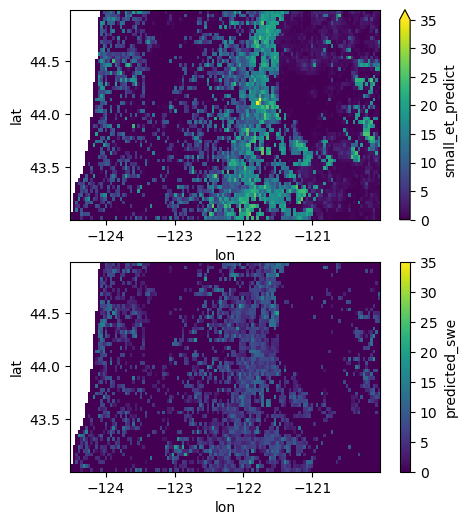

In [12]:
compare_spatial_output(predict_data, ["small_et_predict", "predicted_swe"], plot_args=dict(vmax=35))

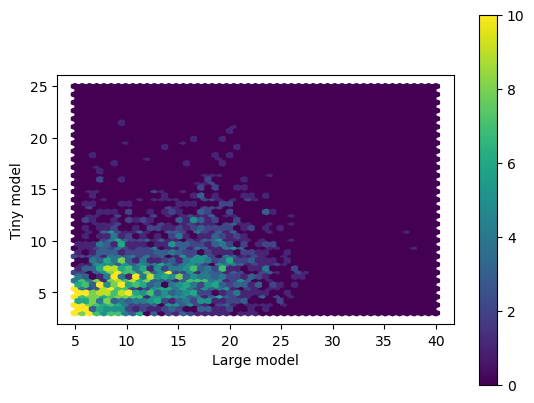

In [16]:
plt.hexbin(predict_data.small_et_predict, predict_data.predicted_swe, vmax=10,
          extent=(5, 40, 3, 25), gridsize=50)
plt.xlabel("Large model")
plt.ylabel("Tiny model")
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

### Train model, accounting for QA flags

A few possibilities:
 - Filter to different quality levels: best, good, ok
 - Add QA flag as a feature

In [17]:
qa = pd.read_csv("/home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small_addedQAflags.csv")
smalldata = pd.read_csv("/home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small.csv")

# join QA flags and drop unreasonable FSCA values
smalljoin = smalldata.merge(qa, how="inner", on=["date", "lat", "lon"])
smalljoin = smalljoin[smalljoin.MOD10A_fsca <= 100]

In [18]:
chosen_columns_qa = [
    'cumulative_SWE',
    'air_temperature_tmmx', 
    'air_temperature_tmmn', 
    'potential_evapotranspiration', 
    'relative_humidity_rmax', 
    'Elevation',	
    'Slope',	
    'Curvature',	
    'Aspect',	
    'Eastness',	
    'Northness',
    'MOD10A_fsca'
]

In [19]:
best_quality = smalljoin[smalljoin.Quality_flag == 0]
et_best = ETHoleTiny()
et_best.preprocess_data(best_quality, verbose=False, chosen_columns=chosen_columns_qa + ["swe_value"])
et_best.fit()
et_best.evaluate()

{'rmse': 2.243859194592689,
 'mae': 0.4922384428223844,
 'r2': 0.5164193557361267}

In [20]:
ok_quality = smalljoin[smalljoin.Quality_flag < 3]
et_ok = ETHoleTiny()
et_ok.preprocess_data(ok_quality, verbose=False, chosen_columns=chosen_columns_qa + ["swe_value"])
et_ok.fit()
et_ok.evaluate()

{'rmse': 3.1487142072503813,
 'mae': 0.6504083885209713,
 'r2': 0.23657344256457646}

In [21]:
predict_data_qa = pd.read_csv("/home/jovyan/shared-public/ml_swe_monitoring_prod/test_data_2023-12-15_MODISwQAflags.csv")
predict_data_qa = predict_data_qa.dropna(subset=chosen_columns_qa)
predict_data_qa = predict_data_qa[predict_data_qa.MOD10A_fsca <= 100]

In [22]:
predict_data_qa["best_quality_prediction"] = et_best.predict(predict_data_qa[chosen_columns_qa])
predict_data_qa["ok_quality_prediction"] = et_ok.predict(predict_data_qa[chosen_columns_qa])

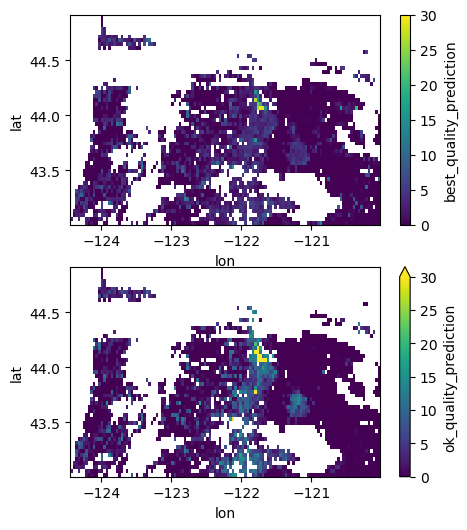

In [23]:
compare_spatial_output(predict_data_qa, ["best_quality_prediction", "ok_quality_prediction"],
                      plot_args=dict(vmin=0, vmax=30))